In [5]:
#Ignoring TF warning messages
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [7]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.


In [8]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE
)

Found 1000 files belonging to 2 classes.


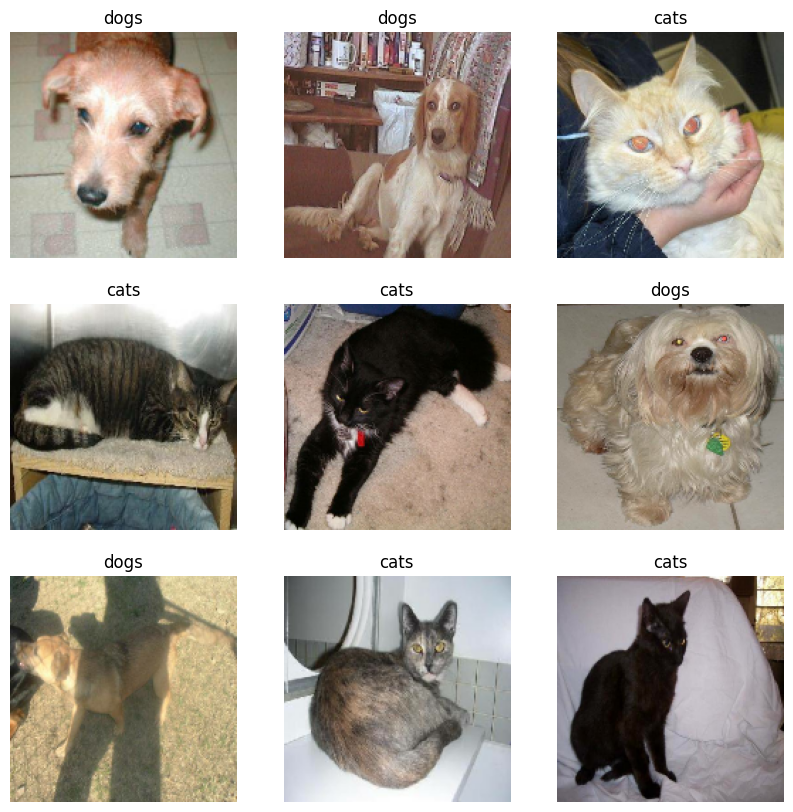

In [9]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [11]:
print(
    "Number of validation batches: %d"
    % tf.data.experimental.cardinality(validation_dataset)
)
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [13]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
    ]
)

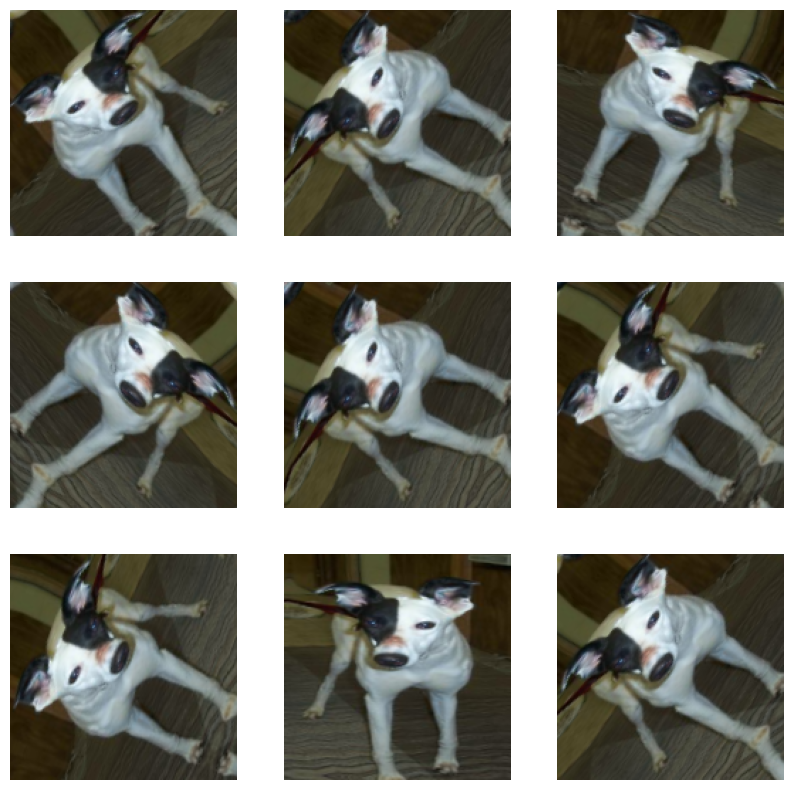

In [14]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")

In [15]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [16]:
rescale = tf.keras.layers.Rescaling(1.0 / 127.5, offset=-1)

In [17]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE, include_top=False, weights="imagenet"
)

9406464/9406464 [==============================] - 3s 0us/step


In [18]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2024-03-15 15:03:30.839737: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


(32, 5, 5, 1280)


In [19]:
base_model.trainable = False

In [20]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [22]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [23]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [25]:
len(model.trainable_variables)

2

In [26]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 4s 46ms/step - loss: 0.9918 - accuracy: 0.3119


In [27]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.99
initial accuracy: 0.31


In [28]:
history = model.fit(
    train_dataset, epochs=initial_epochs, validation_data=validation_dataset
)

Epoch 1/10


2024-03-15 15:03:43.532336: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1b2800b740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-15 15:03:43.532397: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-03-15 15:03:43.569013: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710495223.729785   48860 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 [==============================] - 7s 37ms/step - loss: 0.7951 - accuracy: 0.5030 - val_loss: 0.6611 - val_accuracy: 0.6213
Epoch 2/10
63/63 [==============================] - 2s 30ms/step - loss: 0.5956 - accuracy: 0.6585 - val_loss: 0.4754 - val_accuracy: 0.7834
Epoch 3/10
63/63 [==============================] - 2s 31ms/step - loss: 0.4627 - accuracy: 0.7640 - val_loss: 0.3645 - val_accuracy: 0.8329
Epoch 4/10
63/63 [==============================] - 2s 29ms/step - loss: 0.3867 - accuracy: 0.8145 - val_loss: 0.2946 - val_accuracy: 0.8738
Epoch 5/10
63/63 [==============================] - 2s 30ms/step - loss: 0.3313 - accuracy: 0.8405 - val_loss: 0.2460 - val_accuracy: 0.9047
Epoch 6/10
63/63 [==============================] - 2s 31ms/step - loss: 0.2950 - accuracy: 0.8615 - val_loss: 0.2112 - val_accuracy: 0.9158
Epoch 7/10
63/63 [==============================] - 2s 30ms/step - loss: 0.2692 - accuracy: 0.8795 - val_loss: 0.1867 - val_accuracy: 0.9344
Epoch 8/10
63/63 [======

In [29]:
base_model.trainable = True

In [30]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 10),
    metrics=["accuracy"],
)

In [31]:
len(model.trainable_variables)

158

In [32]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset,
)

Epoch 10/20
63/63 [==============================] - 35s 162ms/step - loss: 0.1548 - accuracy: 0.9385 - val_loss: 0.0712 - val_accuracy: 0.9777
Epoch 11/20
63/63 [==============================] - 5s 74ms/step - loss: 0.1154 - accuracy: 0.9510 - val_loss: 0.0771 - val_accuracy: 0.9777
Epoch 12/20
63/63 [==============================] - 5s 75ms/step - loss: 0.1025 - accuracy: 0.9580 - val_loss: 0.0546 - val_accuracy: 0.9802
Epoch 13/20
63/63 [==============================] - 5s 81ms/step - loss: 0.0902 - accuracy: 0.9655 - val_loss: 0.0524 - val_accuracy: 0.9752
Epoch 14/20
63/63 [==============================] - 5s 74ms/step - loss: 0.0680 - accuracy: 0.9725 - val_loss: 0.0840 - val_accuracy: 0.9666
Epoch 15/20
63/63 [==============================] - 5s 82ms/step - loss: 0.0750 - accuracy: 0.9710 - val_loss: 0.0499 - val_accuracy: 0.9777
Epoch 16/20
63/63 [==============================] - 5s 73ms/step - loss: 0.0593 - accuracy: 0.9760 - val_loss: 0.0949 - val_accuracy: 0.9641
Epoc

Predictions:
 [0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 0 0 1 0 0]
Labels:
 [0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0]


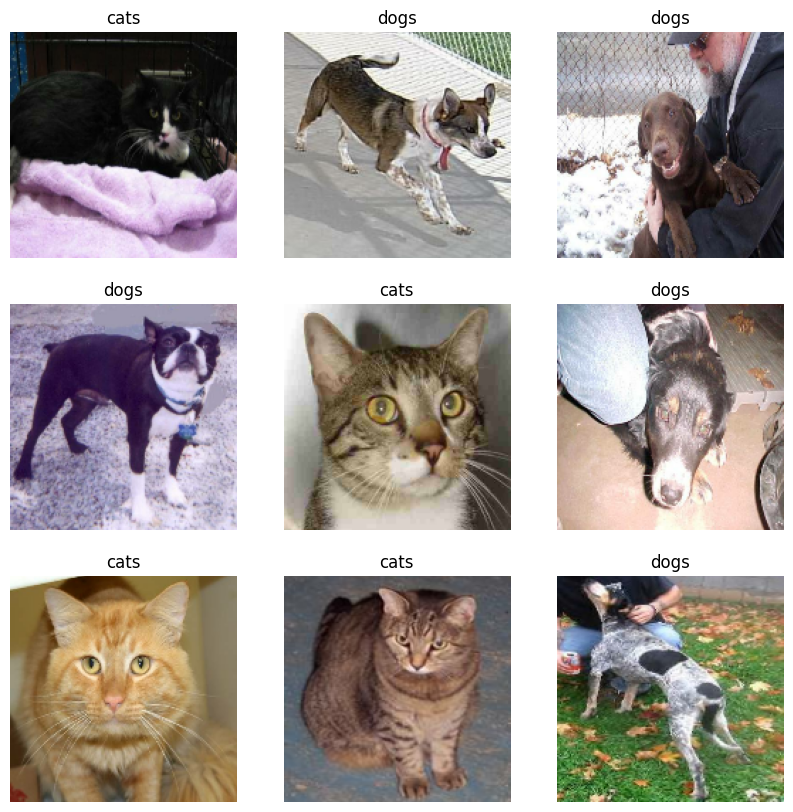

In [33]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [34]:
# Save the model
model_name = "cat-dog-tuned"
model.save(model_name)